In [55]:
%pylab inline
np.set_printoptions(suppress=True)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline 
import matplotlib.pyplot as plt
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [56]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
len(train_df)

42000

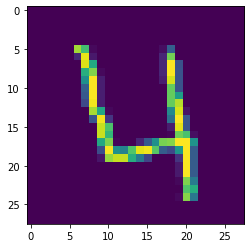

In [58]:
index = 3
image = train_df.drop('label',axis=1).values
plt.imshow(image[index].reshape(28,28))

In [59]:
def convert_to_one_hot(Y, C):
    one_hot = torch.zeros(Y.shape[0],10)
    for label,i in zip(Y,range(Y.shape[0])):
        one_hot[i][label] = 1
    return one_hot

In [60]:
#places x and y in tensors
Y_train = torch.tensor(train_df.label.values)
X_train_orig = torch.tensor(train_df.drop('label',axis=1).values)
X_test_orig = torch.tensor(test_df.values)
#flatten images
X_train_flatten = X_train_orig.reshape((-1,1,28,28))
X_test_flatten = X_test_orig.reshape((-1,1,28,28))
# #normalize
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
#convert labels to one hot tensors
Y_train = convert_to_one_hot(Y_train,10)
Y_train.shape,X_train.shape

(torch.Size([42000, 10]), torch.Size([42000, 1, 28, 28]))

In [61]:
#model
class ApdNet(torch.nn.Module):
    def __init__(self):
        super(ApdNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self,x):
        #Max pooling over (2,2) window
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

loss 0.01 accuracy 1.00: 100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]


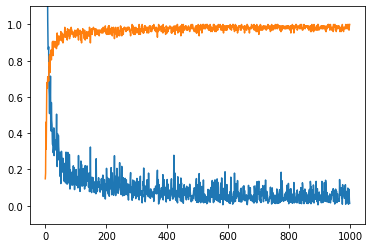

In [103]:
#training
model = ApdNet()
BS = 128
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)
# optim = torch.optim.SGD(model.parameters(),lr=0.01)
losses, accuracies = [],[]
for i in (t := trange(1000)):
    samp = np.random.randint(0,X_train.shape[0], size=(BS))
    X = X_train[samp]
    Y = Y_train[samp]
    optim.zero_grad()
    out = model(X)
    cat = torch.max(out,dim=1)[1]
    accuracy = (cat == torch.max(Y,1)[1]).float().mean()
    loss = loss_function(out,torch.max(Y,1)[1])
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(),accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss,accuracy))

plt.ylim(-0.1,1.1)
plot(losses)
plot(accuracies)

In [105]:
model.eval()
output = model(X_test)
print(output.shape)
preds = {}
for pred,i in zip(output,range(len(output))):
#     print(torch.argmax(pred))
    preds[i+1] = int(torch.argmax(pred))
df = pd.DataFrame(preds.items())
df.style.hide_index
df.columns = ['ImageId','Label']
df.to_csv('submission.csv',index=False)

torch.Size([28000, 10])
